## Set up environment

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [92]:
%matplotlib inline

## Read animelist.csv

In [93]:
import os

In [94]:
INPUT_DIR = os.path.join("..", "artifacts", "raw")

In [95]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv" , low_memory = True,usecols = ["user_id","anime_id","rating"])

In [96]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [97]:
len(rating_df)

10000000

## Data Processing

In [98]:
n_ratings = rating_df["user_id"].value_counts()

In [60]:
n_ratings

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
9442         1
449          1
443          1
12314        1
16074        1
Name: count, Length: 15186, dtype: int64

In [99]:
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings >= 400].index)].copy()

In [100]:
len(rating_df)

6529917

In [101]:
min_rating = min(rating_df["rating"])
max_rating = max(rating_df["rating"])
avg_rating = np.mean(rating_df["rating"])

In [102]:
min_rating, max_rating, avg_rating

(0, 10, np.float64(4.073779191986667))

Scale rating

In [103]:
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

Check duplicate and missing values

In [104]:
rating_df.duplicated().sum()

np.int64(0)

In [105]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

Encode and decode UserId

In [106]:
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user2user_decoded = {i: x for i, x in enumerate(user_ids)}

In [22]:
user2user_encoded

{2: 0,
 6: 1,
 12: 2,
 16: 3,
 17: 4,
 19: 5,
 21: 6,
 41: 7,
 42: 8,
 44: 9,
 47: 10,
 53: 11,
 55: 12,
 60: 13,
 66: 14,
 73: 15,
 74: 16,
 85: 17,
 89: 18,
 90: 19,
 94: 20,
 98: 21,
 102: 22,
 108: 23,
 111: 24,
 112: 25,
 120: 26,
 121: 27,
 122: 28,
 135: 29,
 145: 30,
 146: 31,
 147: 32,
 153: 33,
 155: 34,
 156: 35,
 172: 36,
 174: 37,
 184: 38,
 190: 39,
 193: 40,
 194: 41,
 198: 42,
 204: 43,
 205: 44,
 209: 45,
 214: 46,
 219: 47,
 222: 48,
 227: 49,
 228: 50,
 235: 51,
 238: 52,
 240: 53,
 243: 54,
 248: 55,
 251: 56,
 252: 57,
 257: 58,
 264: 59,
 267: 60,
 272: 61,
 274: 62,
 275: 63,
 284: 64,
 285: 65,
 286: 66,
 290: 67,
 291: 68,
 293: 69,
 300: 70,
 301: 71,
 306: 72,
 308: 73,
 310: 74,
 313: 75,
 314: 76,
 316: 77,
 320: 78,
 321: 79,
 324: 80,
 325: 81,
 326: 82,
 327: 83,
 330: 84,
 336: 85,
 340: 86,
 345: 87,
 346: 88,
 349: 89,
 350: 90,
 366: 91,
 367: 92,
 371: 93,
 372: 94,
 375: 95,
 381: 96,
 382: 97,
 386: 98,
 389: 99,
 398: 100,
 405: 101,
 406: 102,
 

In [24]:
user2user_decoded

{0: 2,
 1: 6,
 2: 12,
 3: 16,
 4: 17,
 5: 19,
 6: 21,
 7: 41,
 8: 42,
 9: 44,
 10: 47,
 11: 53,
 12: 55,
 13: 60,
 14: 66,
 15: 73,
 16: 74,
 17: 85,
 18: 89,
 19: 90,
 20: 94,
 21: 98,
 22: 102,
 23: 108,
 24: 111,
 25: 112,
 26: 120,
 27: 121,
 28: 122,
 29: 135,
 30: 145,
 31: 146,
 32: 147,
 33: 153,
 34: 155,
 35: 156,
 36: 172,
 37: 174,
 38: 184,
 39: 190,
 40: 193,
 41: 194,
 42: 198,
 43: 204,
 44: 205,
 45: 209,
 46: 214,
 47: 219,
 48: 222,
 49: 227,
 50: 228,
 51: 235,
 52: 238,
 53: 240,
 54: 243,
 55: 248,
 56: 251,
 57: 252,
 58: 257,
 59: 264,
 60: 267,
 61: 272,
 62: 274,
 63: 275,
 64: 284,
 65: 285,
 66: 286,
 67: 290,
 68: 291,
 69: 293,
 70: 300,
 71: 301,
 72: 306,
 73: 308,
 74: 310,
 75: 313,
 76: 314,
 77: 316,
 78: 320,
 79: 321,
 80: 324,
 81: 325,
 82: 326,
 83: 327,
 84: 330,
 85: 336,
 86: 340,
 87: 345,
 88: 346,
 89: 349,
 90: 350,
 91: 366,
 92: 367,
 93: 371,
 94: 372,
 95: 375,
 96: 381,
 97: 382,
 98: 386,
 99: 389,
 100: 398,
 101: 405,
 102: 406,
 

In [107]:
n_users = len(user2user_encoded)
n_users

8348

In [108]:
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

In [109]:
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [110]:
len(user2user_encoded)

8348

Encode and decode AnimeID

In [111]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime2anime_decoded = {i: x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [112]:
n_animes = len(anime2anime_encoded)
n_animes

17554

In [113]:
rating_df.head()

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4


Shuffle data

In [114]:
rating_df = rating_df.sample(frac=1, random_state=2001).reset_index(drop=True)

Split into X and Y

In [115]:
X = rating_df[["user", "anime"]].values
y = rating_df["rating"]

In [117]:
test_size = 2000
train_indices = rating_df.shape[0] - test_size

In [118]:
X_train, X_test, y_train, y_test = X[:train_indices], X[train_indices:], y[:train_indices], y[train_indices:]

In [119]:
len(X_train), len(X_test), len(y_train), len(y_test)

(6527917, 2000, 6527917, 2000)

In [120]:
type(X_train)

numpy.ndarray

In [121]:
X_train_array = [X_train[:,0], X_train[:,1]]
X_test_array = [X_test[:,0], X_test[:,1]]

## Model Architecture

In [122]:
def RecommenderNet():
    # Input and embedding for users and anime
    embedding_size = 128

    user = Input(name = "user", shape = [1])
    user_embedding = Embedding(name = "user_embedding", input_dim = n_users, output_dim = embedding_size)(user)

    anime = Input(name = "anime", shape = [1])
    anime_embedding = Embedding(name = "anime_embedding", input_dim = n_animes, output_dim = embedding_size)(anime)

    # Similarity score using dot product
    x = Dot(name = "dot_product", normalize = True, axes = 2)([user_embedding, anime_embedding])

    # Flatten the result
    x = Flatten()(x)

    # Add a dense layer
    x = Dense(1, kernel_initializer = "he_normal")(x)

    # Batch normalization
    x = BatchNormalization()(x)

    # Activation function
    x = Activation("sigmoid")(x)

    # Model
    model = Model(inputs = [user, anime], outputs = x)
    model.compile(loss = "binary_crossentropy", metrics = ["mae", "mse"], optimizer = "Adam")
    return model
    

In [123]:
model = RecommenderNet()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │  1,068,544 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,246,912 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │          2 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,315,462 (12.65 MB)

 Trainable params: 3,315,460 (12.65 MB)

 Non-trainable params: 2 (8.00 B)

In [124]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch < ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch < ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs) + min_lr


In [125]:
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch) , verbose = 0)

checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only = True, monitor = "val_loss", mode = "min", save_best_only = True)

early_stopping = EarlyStopping(patience = 3, monitor = "val_loss", mode = "min", restore_best_weights = True)

In [126]:
my_callbacks = [lr_callback, model_checkpoint, early_stopping]

In [127]:
history = model.fit(
    x = X_train_array,
    y = y_train,
    batch_size = batch_size,
    epochs = 20,
    verbose = 1,
    validation_data = (X_test_array, y_test),
    callbacks = my_callbacks
)

Epoch 1/20
653/653 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.7294 - mae: 0.3697 - mse: 0.1728 - val_loss: 0.7120 - val_mae: 0.3688 - val_mse: 0.1671 - learning_rate: 1.0000e-05
Epoch 2/20
653/653 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.7246 - mae: 0.3683 - mse: 0.1707 - val_loss: 0.7256 - val_mae: 0.3714 - val_mse: 0.1729 - learning_rate: 1.8000e-05
Epoch 3/20
653/653 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.7173 - mae: 0.3661 - mse: 0.1674 - val_loss: 0.7192 - val_mae: 0.3701 - val_mse: 0.1701 - learning_rate: 2.6000e-05
Epoch 4/20
653/653 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.7078 - mae: 0.3631 - mse: 0.1630 - val_loss: 0.7109 - val_mae: 0.3681 - val_mse: 0.1664 - learning_rate: 3.4000e-05
Epoch 5/20
653/653 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.6958 - mae: 0.3589 - mse: 0.1574 - val_loss: 0.6990 - val_mae: 0.3642 - val_mse: 0.1608 - learning_rate: 4.2000e-05
Epoch 6/20
653/653 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.6787 - mae: 0.3512 - mse: 0.1492 - val_los

In [128]:
model.load_weights(checkpoint_filepath)

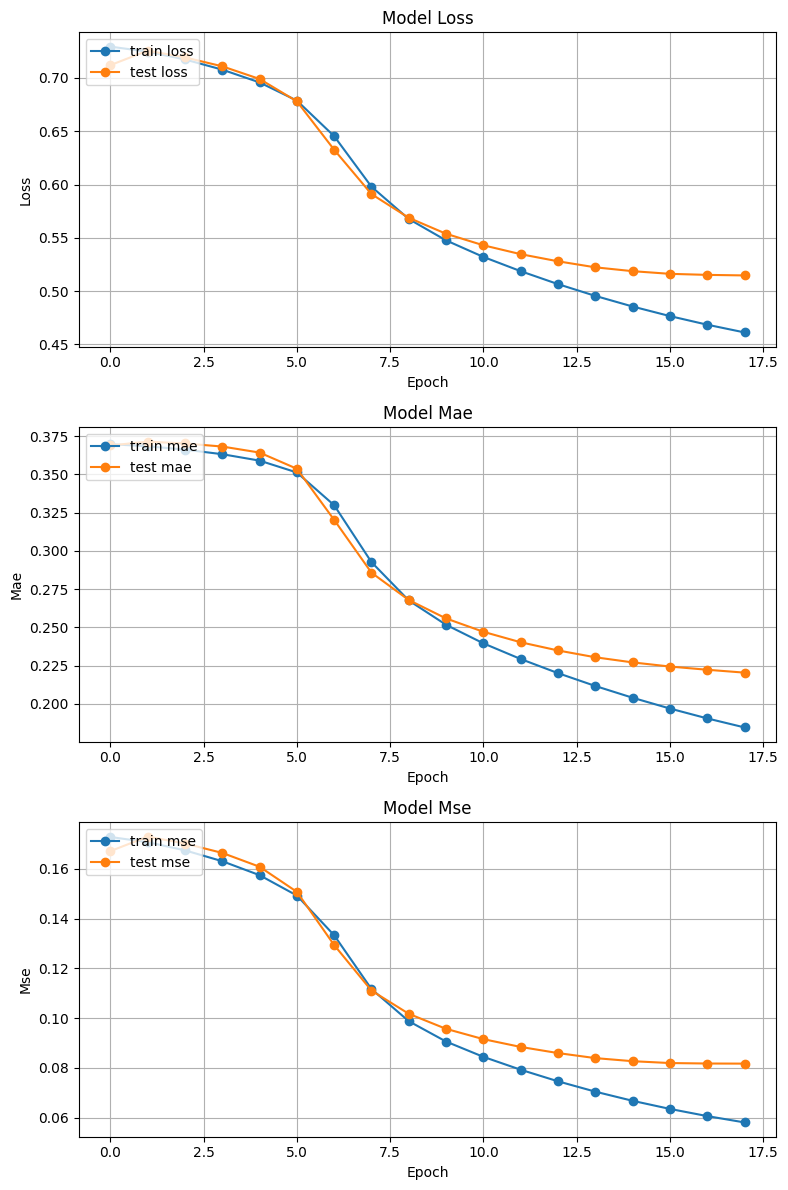

In [129]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [130]:
def extract_weights(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights, axis = 1).reshape((-1,1))
    return weights

In [131]:
anime_weights = extract_weights("anime_embedding", model)
user_weights = extract_weights("user_embedding", model)

## Reading Anime.csv

In [132]:
df = pd.read_csv(INPUT_DIR+"/anime.csv", low_memory = True)
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,Victor Entertainment,"Funimation, Geneon Entertainment USA",Madhouse,Manga,24 min. per ep.,PG-13 - Teens 13 or older,266.0,201,558913,12944,29113,343492,25465,13925,146918,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,"TV Tokyo, Bandai Visual, Dentsu, Victor Entert...","Funimation, Bandai Entertainment",Sunrise,Original,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,1467,94683,587,4300,46165,5121,5378,33719,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,"TV Tokyo, Dentsu",Unknown,Toei Animation,Manga,23 min. per ep.,PG - Children,3710.0,4369,13224,18,642,7314,766,1108,3394,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [133]:
df = df.replace("Unknown", np.nan)

In [134]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name

In [135]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x: getAnimeName(x))

In [136]:
getAnimeName(15)

'Eyeshield 21'

In [137]:
df.sort_values(by = ["Score"],
               inplace = True,
               ascending = False,
               kind = "quicksort",
               na_position = "last")

In [138]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [139]:
df = df[["anime_id" , "eng_version", "Score", "Genres", "Episodes", "Type", "Premiered", "Members"]]
df.head(5)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [141]:
def getAnimeFrame(anime, df):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    if isinstance(anime, str):
        return df[df.eng_version == anime]

In [142]:
getAnimeFrame(38524, df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626


In [143]:
getAnimeFrame("Fairy Tail", df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
4707,6702,Fairy Tail,7.68,"Action, Adventure, Comedy, Magic, Fantasy, Sho...",175,TV,Fall 2009,1312470


## Anime_with_synopsis.csv

In [144]:
cols = ["MAL_ID", "Name", "Genres", "sypnopsis"]

In [145]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv", low_memory = True, usecols = cols)
synopsis_df.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [146]:
def getSynopsis(anime, synopsis_df):
    if isinstance(anime, int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime, str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]

In [147]:
getSynopsis(38524, synopsis_df)

'Seeking to restore humanity\'s diminishing hope, the Survey Corps embark on a mission to retake Wall Maria, where the battle against the merciless "Titans" takes the stage once again. Returning to the tattered Shiganshina District that was once his home, Eren Yeager and the Corps find the town oddly unoccupied by Titans. Even after the outer gate is plugged, they strangely encounter no opposition. The mission progresses smoothly until Armin Arlert, highly suspicious of the enemy\'s absence, discovers distressing signs of a potential scheme against them. Shingeki no Kyojin Season 3 Part 2 follows Eren as he vows to take back everything that was once his. Alongside him, the Survey Corps strive—through countless sacrifices—to carve a path towards victory and uncover the secrets locked away in the Yeager family\'s basement.'

## Content/Item Based Recommendation

In [148]:
pd.set_option("max_colwidth", None)

In [151]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, 
                        df, synopsis_df, n = 10, return_dist = False, neg = False):
    try: 
        # Get the anime_id for the given name
        index = getAnimeFrame(name, df).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)

        if encoded_index is None:
            raise ValueError(f"Encoded index not found for anime ID: {index}")

        weights = anime_weights

        # Compute the similarity distances
        dists = np.dot(weights, weights[encoded_index])  # Ensure weights[encoded_index] is a 1D array
        sorted_dists = np.argsort(dists)

        n = n + 1

        # Select closest or farthest based on 'neg' flag
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        # Return distances and closest indices if requested
        if return_dist:
            return dists, closest

        # Build the similarity array
        SimilarityArr = []
        for close in closest:
            decoded_id = anime2anime_decoded.get(close)
            anime_frame = getAnimeFrame(decoded_id, df)
            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            synopsis = getSynopsis(decoded_id, synopsis_df)
            similarity = dists[close]
    
            SimilarityArr.append({
                "anime_id": decoded_id,
                "name": anime_name,
                "similarity": similarity,
                "genre": genre,
                "synopsis": synopsis
            })
        
        # Create a DataFrame with results and sort by similarity
        Frame = pd.DataFrame(SimilarityArr).sort_values(by = "similarity", ascending = False)
        return Frame[Frame.anime_id != index].drop(['anime_id'], axis = 1)
    except Exception as e:
        print("Error Occured", e)

In [152]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
)

,name,similarity,genre,synopsis
9,Code Geass:Lelouch of the Rebellion R2,0.784225,"Action, Military, Sci-Fi, Super Power, Drama, Mecha","One year has passed since the Black Rebellion, a failed uprising against the Holy Britannian Empire led by the masked vigilante Zero, who is now missing. At a loss without their revolutionary leader, Area 11's resistance group—the Black Knights—find themselves too powerless to combat the brutality inflicted upon the Elevens by Britannia, which has increased significantly in order to crush any hope of a future revolt. Lelouch Lamperouge, having lost all memory of his double life, is living peacefully alongside his friends as a high school student at Ashford Academy. His former partner C.C., unable to accept this turn of events, takes it upon herself to remind him of his past purpose, hoping that the mastermind Zero will rise once again to finish what he started, in this thrilling conclusion to the series."
8,Code Geass:Lelouch of the Rebellion,0.755827,"Action, Military, Sci-Fi, Super Power, Drama, Mecha, School","In the year 2010, the Holy Empire of Britannia is establishing itself as a dominant military nation, starting with the conquest of Japan. Renamed to Area 11 after its swift defeat, Japan has seen significant resistance against these tyrants in an attempt to regain independence. Lelouch Lamperouge, a Britannian student, unfortunately finds himself caught in a crossfire between the Britannian and the Area 11 rebel armed forces. He is able to escape, however, thanks to the timely appearance of a mysterious girl named C.C., who bestows upon him Geass, the ""Power of Kings."" Realizing the vast potential of his newfound ""power of absolute obedience,"" Lelouch embarks upon a perilous journey as the masked vigilante known as Zero, leading a merciless onslaught against Britannia in order to get revenge once and for all."
7,Fullmetal Alchemist:Brotherhood,0.751717,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen","""In order for something to be obtained, something of equal value must be lost."" Alchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward's right arm that he is able to affix Alphonse's soul to a suit of armor. Devastated and alone, it is the hope that they would both eventually return to their original bodies that gives Edward the inspiration to obtain metal limbs called ""automail"" and become a state alchemist, the Fullmetal Alchemist. Three years of searching later, the brothers seek the Philosopher's Stone, a mythical relic that allows an alchemist to overcome the Law of Equivalent Exchange. Even with military allies Colonel Roy Mustang, Lieutenant Riza Hawkeye, and Lieutenant Colonel Maes Hughes on their side, the brothers find themselves caught up in a nationwide conspiracy that leads them not only to the true nature of the elusive Philosopher's Stone, but their country's murky history as well. In between finding a serial killer and racing against time, Edward and Alphonse must ask themselves if what they are doing will make them human again... or take away their humanity."
6,Fate/Zero Season 2,0.729143,"Action, Supernatural, Magic, Fantasy","s the Fourth Holy Grail War rages on with no clear victor in sight, the remaining Servants and their Masters are called upon by Church supervisor Risei Kotomine, in order to band together and confront an impending threat that could unravel the Grail War and bring about the destruction of Fuyuki City. The uneasy truce soon collapses as Masters demonstrate that they will do anything in their power, no matter how despicable, to win. Seeds of doubt are sown between Kiritsugu Emiya and Saber, his Servant, as their conflicting ideologies o

## User-based Recommendation

In [153]:
def find_similar_users(item_input , user_weights , user2user_encoded , user2user_decoded, n=10 , return_dist=False,neg=False):
    try:
        index=item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n = n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            

        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input,int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by = "similarity",ascending = False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users
    
    except Exception as e:
        print("Error Occured", e)


In [154]:
find_similar_users(int(11880), user_weights, user2user_encoded, user2user_decoded)

,similar_users,similarity
9,8031,0.448176
8,6472,0.424839
7,7470,0.415581
6,20858,0.409049
5,7436,0.402622
4,6758,0.400599
3,12888,0.398361
2,25433,0.394526
1,11134,0.392176
0,12994,0.389529


In [155]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width = 700,height = 400,background_color = 'white',colormap = 'gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize = (10,8))
    plt.imshow(genres_cloud,interpolation = "bilinear")
    plt.axis("off")
    plt.show()

In [159]:
from collections import defaultdict

def getFavGenre(frame , plot = False):
    frame.dropna(inplace = False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres, str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)
    
    return genres_list

In [157]:
def get_user_preferences(user_id , rating_df , df ,plot=False):

    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by = "rating" , ascending = False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]

    if plot:
        getFavGenre(anime_df_rows,plot)

    return anime_df_rows

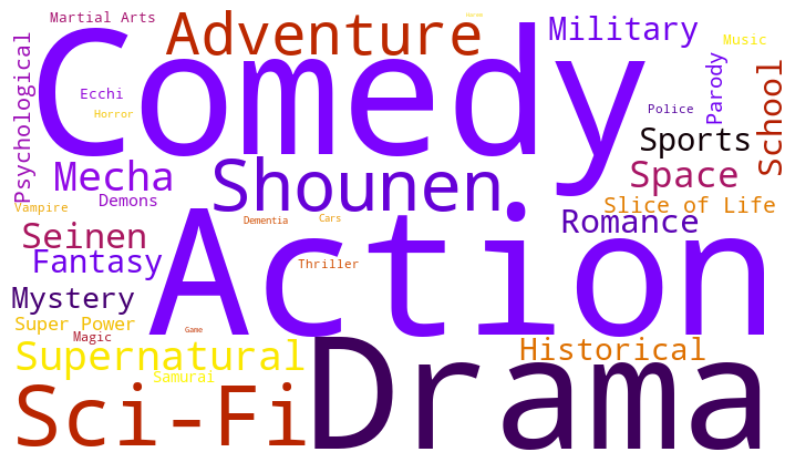

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [160]:
get_user_preferences(11880, rating_df, df, plot=True)

In [ ]:
def get_user_recommendations(similar_users, user_pref, df , synopsis_df, rating_df, n = 10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id), rating_df, df)
        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)
            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i, anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name, str):
                    frame = getAnimeFrame(anime_name, df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id), synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres" : genre,
                        "Synopsis": synopsis
                    })
    return pd.DataFrame(recommended_animes).head(n)

In [ ]:
similar_users = find_similar_users(int(11880), user_weights, user2user_encoded, user2user_decoded)
user_pref = get_user_preferences(11880, rating_df, df, plot=False)
get_user_recommendations(similar_users, user_pref, df, synopsis_df, rating_df, n=5)

,n,anime_name,Genres,Synopsis
0,10,"No Game, No Life","Game, Adventure, Comedy, Supernatural, Ecchi, Fantasy","No Game No Life is a surreal comedy that follows Sora and Shiro, shut-in NEET siblings and the online gamer duo behind the legendary username ""Blank."" They view the real world as just another lousy game; however, a strange e-mail challenging them to a chess match changes everything—the brother and sister are plunged into an otherworldly realm where they meet Tet, the God of Games. The mysterious god welcomes Sora and Shiro to Disboard, a world where all forms of conflict—from petty squabbles to the fate of whole countries—are settled not through war, but by way of high-stake games. This system works thanks to a fundamental rule wherein each party must wager something they deem to be of equal value to the other party's wager. In this strange land where the very idea of humanity is reduced to child's play, the indifferent genius gamer duo of Sora and Shiro have finally found a real reason to keep playing games: to unite the sixteen races of Disboard, defeat Tet, and become the gods of this new, gaming-is-everything world."
1,9,Code Geass:Lelouch of the Rebellion R2,"Action, Military, Sci-Fi, Super Power, Drama, Mecha","One year has passed since the Black Rebellion, a failed uprising against the Holy Britannian Empire led by the masked vigilante Zero, who is now missing. At a loss without their revolutionary leader, Area 11's resistance group—the Black Knights—find themselves too powerless to combat the brutality inflicted upon the Elevens by Britannia, which has increased significantly in order to crush any hope of a future revolt. Lelouch Lamperouge, having lost all memory of his double life, is living peacefully alongside his friends as a high school student at Ashford Academy. His former partner C.C., unable to accept this turn of events, takes it upon herself to remind him of his past purpose, hoping that the mastermind Zero will rise once again to finish what he started, in this thrilling conclusion to the series."
2,9,Berserk,"Action, Adventure, Demons, Drama, Fantasy, Horror, Military, Romance, Seinen, Supernatural","Born from the corpse of his mother, a young mercenary known only as Guts, embraces the battlefield as his only means of survival. Day in and day out, putting his life on the line just to make enough to get by, he moves from one bloodshed to the next. After a run-in with the Band of the Hawk, a formidable troop of mercenaries, Guts is recruited by their charismatic leader Griffith, nicknamed the ""White Hawk."" As he quickly climbed the ranks in order to become the head of the offensive faction, Guts proves to be a mighty addition to Griffith's force, taking Midland by storm. However, while the band's quest for recognition continues, Guts slowly realizes that the world is not as black-and-white as he once assumed. Set in the medieval era, Kenpuu Denki Berserk is a dark, gritty tale that follows one man's struggle to find his own path, while supporting another's lust for power, and the unimaginable tragedy that begins to turn the wheels of fate."
3,9,Code Geass:Lelouch of the Rebellion,"Action, Military, Sci-Fi, Super Power, Drama, Mecha, School","In the year 2010, the Holy Empire of Britannia is establishing itself as a dominant military nation, starting with the conquest of Japan. Renamed to Area 11 after its swift defeat, Japan has seen significant resistance against these tyrants in an attempt to regain independence. Lelouch Lamperouge, a Britannian student, unfortunately finds himself caught in a crossfire between the Britannian and the Area 11 rebel armed forces. He is able to escape, however, thanks to the timely appearance of a mysterious girl named C.C., who bestows upon him Geass, the ""Power of Kings."" Realizing the vast potential of his newfound ""power of absolute obedience,"" Lelouch embarks upon a perilous journey as the masked vigilante known as Zero, leading a merciless onslaught ag

## Hybrid Recommender System

In [167]:
def hybrid_recommendation(user_id, user_weight=0.5, content_weight =0.5):

    ## User Recommndation
    similar_users = find_similar_users(user_id, user_weights, user2user_encoded, user2user_decoded)
    user_pref = get_user_preferences(user_id, rating_df, df)
    user_recommended_animes = get_user_recommendations(similar_users, user_pref, df, synopsis_df, rating_df)
    
    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()

    ## Content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")
    
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime, 0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime, 0) + content_weight  

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True)

    return [anime for anime, score in sorted_animes[:10]] 

In [168]:
hybrid_recommendation(11880)

['No Game, No Life',
 'Code Geass:Lelouch of the Rebellion R2',
 'Attack on Titan',
 'Sword Art Online',
 'One Punch Man',
 'Death Note',
 'Fullmetal Alchemist:Brotherhood',
 'Angel Beats!',
 'Code Geass:Lelouch of the Rebellion',
 'Steins;Gate']